# Hyperparameter Optimization with Hyperopt



## Install Hyperopt package

In [1]:
!pip install hyperopt

## Import required libraries

In [2]:
import warnings
warnings.simplefilter('ignore')
from ludwig.api import LudwigModel
from ludwig.utils.data_utils import load_json
from ludwig.visualize import learning_curves
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.stochastic import rng_from_seed
import logging
import shutil

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
# clean out old results
try:
    shutil.rmtree('./results')
except:
    pass

try:
    shutil.rmtree('./visualizations')
except:
    pass

try:
    file_list = glob.glob('./data/*.json')
    file_list.append(glob.glob('./data/*.hdf5'))
    os.remove(file_list)
except:
    pass


## Retrieve data for training

In [4]:
raw_df = pd.read_csv('./data/winequalityN.csv')
raw_df.shape

(6497, 13)

## Standardize column names to replace spaces(" ") with underscore("_")

In [5]:
new_col = []
for i in range(len(raw_df.columns)):
    new_col.append(raw_df.columns[i].replace(' ', '_'))
    
raw_df.columns = new_col


## Data Set Overview

In [6]:
raw_df.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [7]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,6487.0,7.216579,1.296750,3.80000,6.40000,7.00000,7.70000,15.90000
volatile_acidity,6489.0,0.339691,0.164649,0.08000,0.23000,0.29000,0.40000,1.58000
citric_acid,6494.0,0.318722,0.145265,0.00000,0.25000,0.31000,0.39000,1.66000
residual_sugar,6495.0,5.444326,4.758125,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6495.0,0.056042,0.035036,0.00900,0.03800,0.04700,0.06500,0.61100
free_sulfur_dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total_sulfur_dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488.0,3.218395,0.160748,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6493.0,0.531215,0.148814,0.22000,0.43000,0.51000,0.60000,2.00000


## Create training and test data sets

In [8]:
train_df, vald_df = train_test_split(raw_df, test_size = 0.2, random_state=13)
print(train_df.shape, vald_df.shape)

(5197, 13) (1300, 13)


## Prepare model definition

In [9]:
# template for model definition
model_definition = {'input_features':[], 'output_features': [], 'training':{}}

# isolate the predictor variables only
predictor_vars = list(set(raw_df.columns) - set(['quality']))

#extract categorical variables
categorical_vars = []
for p in predictor_vars:
    if raw_df[p].dtype == 'object':
        categorical_vars.append(p)

# get numerical variables
numerical_vars = list(set(predictor_vars) - set(categorical_vars))

# setup input features for categorical variables
for p in categorical_vars:
    
    a_feature = {'name': p.replace(' ','_'), 'type': 'category', 'representation': 'sparse'}
    model_definition['input_features'].append(a_feature)


# setup input features for numerical variables
for p in numerical_vars:
    a_feature = {'name': p.replace(' ','_'), 'type': 'numerical', 
                'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'zscore'}}
    model_definition['input_features'].append(a_feature)

# set up output variable
model_definition['output_features'].append({'name': 'quality', 'type':'category'})

In [10]:
model_definition

{'input_features': [{'name': 'type',
   'type': 'category',
   'representation': 'sparse'},
  {'name': 'pH',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'free_sulfur_dioxide',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'residual_sugar',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'density',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'total_sulfur_dioxide',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'sulphates',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'fix

## Define objective function for minimization

In [11]:
def score_model(params):
    
    print(params)
    
    model_definition['training']['learning_rate'] = params['learning_rate']
    model_definition['training']['batch_size'] = params['batch_size']
    model_definition['output_features'][0]['num_fc_layers'] = np.int(params['output_fc_num_layers'])
    model_definition['output_features'][0]['fc_size'] = np.int(params['output_fc_size'])
    
    # Define Ludwig model object that drive model training
    model = LudwigModel(model_definition,
                        logging_level=logging.WARN)

    # initiate model training
    train_stats = model.train(data_train_df = train_df,
                            data_validation_df = vald_df,
                            experiment_name='experiment_name',
                            model_name='model_name',
                            skip_save_training_description=True, 
                            skip_save_training_statistics=True, 
                            skip_save_model=True, 
                            skip_save_progress=True,                          
                            skip_save_log=True,
                            skip_save_processed_input=True,
                            random_seed=42)



    model.close()
    
    validation_losses = train_stats['validation']['quality']['loss']
    
    last_epoch = len(validation_losses)
    
    return {'loss': validation_losses[last_epoch - 1], 'status': STATUS_OK}

## Define hyperparameter search space

In [12]:
SEED=13

space = {'learning_rate':  hp.uniform('learning_rate', 0.0001, 0.01, rng=rng_from_seed(SEED)),
         'batch_size': 2 ** (5 + hp.randint('batch_size_exponent',3, rng=rng_from_seed(SEED))),
         'output_fc_num_layers': hp.quniform('output_fc_num_layers',1,4,1, rng=rng_from_seed(SEED)),
         'output_fc_size': hp.quniform('output_fc_size',5,100,1, rng=rng_from_seed(SEED))
        }

In [13]:
np.random.seed(123)
best = fmin(fn=score_model,
    space=space,
    algo=tpe.suggest,
    max_evals=30)

{'batch_size': 32, 'learning_rate': 0.0014178618831807194, 'output_fc_num_layers': 2.0, 'output_fc_size': 52.0}
  0%|          | 0/30 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

{'batch_size': 64, 'learning_rate': 0.0001645774200513777, 'output_fc_num_layers': 4.0, 'output_fc_size': 81.0}
{'batch_size': 64, 'learning_rate': 0.00918554006842912, 'output_fc_num_layers': 4.0, 'output_fc_size': 26.0}
{'batch_size': 32, 'learning_rate': 0.004783527970946766, 'output_fc_num_layers': 4.0, 'output_fc_size': 91.0}
{'batch_size': 64, 'learning_rate': 0.008044943390364427, 'output_fc_num_layers': 2.0, 'output_fc_size': 6.0}
{'batch_size': 64, 'learning_rate'

## Optimal hyperparameters

In [14]:
print('batch size:', 2 ** np.int(3 + best['batch_size_exponent']),
      ', learning_rate:', best['learning_rate'],
      ', fc_num_layers:', np.int(best['output_fc_num_layers']),
      ', fc_size:', np.int(best['output_fc_size']))

batch size: 16 , learning_rate: 0.0001645774200513777 , fc_num_layers: 4 , fc_size: 81


## Train with optimal hyperparameters on the whole data set

In [15]:
# clean out old results
try:
    shutil.rmtree('./results')
except:
    pass

try:
    shutil.rmtree('./visualizations')
except:
    pass



In [16]:
# set optimal hyperparameters for training    
model_definition['training']['learning_rate'] = best['learning_rate']
model_definition['training']['batch_size'] = 2** (3 + best['batch_size_exponent'])
model_definition['output_features'][0]['num_fc_layers'] = np.int(best['output_fc_num_layers'])
model_definition['output_features'][0]['fc_size'] = np.int(best['output_fc_size'])


# Define Ludwig model object that drive model training
model = LudwigModel(model_definition,
                    logging_level=logging.WARN)

# initiate model training
opt_stats = model.train(data_df = raw_df,
                        experiment_name='hyperparameter_training',
                        model_name='optimized_model',                        
                        random_seed=42)



model.close()


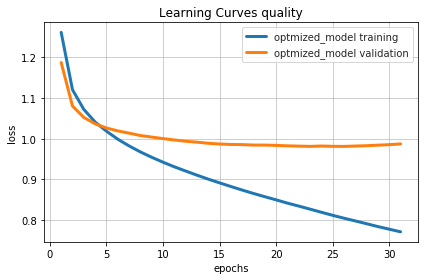

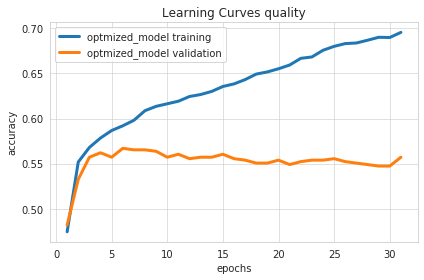

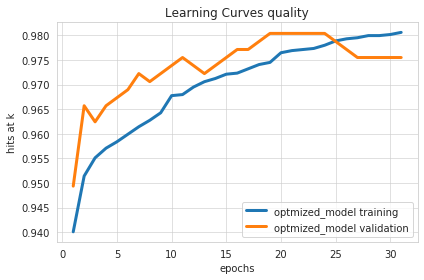

In [17]:
# generating learning curves from training
learning_curves([opt_stats], 'quality',
                model_names=['optmized_model'],
                output_directory='./visualizations',
                file_format='png')